#**Discovering Key-Drivers for Boosting Thailand's Digital Competitiveness Index Using an NLP Approach**
---
Pichaya Charoonpongsakdi (Anik) <br>
GA-TDA DSI Capstone Project

# **Part 0: Problem Statement**
---

#**Part 1: Data Preparation**
---


##1.0 Install and Import Libraries

In [1]:
# COLAB
# Install pythainlp library
# !pip install pythainlp

In [2]:
# Import Basic Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Sklearn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import NLP Libraries
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from pythainlp.tokenize import sent_tokenize, word_tokenize
from pythainlp.corpus import thai_stopwords
import re
from tqdm import tqdm 
import pyLDAvis
import pyLDAvis.gensim_models


# Set default Thai font
mpl.font_manager.fontManager.addfont('./THSarabunNew/THSarabunNew.ttf')
mpl.rc('font', family='TH Sarabun New', size=20)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# COLAB
# Other Libraries
# from google.colab import files
# from google.colab import drive

/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# COLAB
# Download TH Sarabun (Thai font)
# !gdown 1rZSpiIh6fTeaDPOCKvamgtlR3qN2UQEl

# Set TH Sarabun as default Thai font
# mpl.font_manager.fontManager.addfont('/content/THSarabunNew.ttf')
# mpl.rc('font', family='TH Sarabun New', size=20)

## 1.1 Load Datasets

In [4]:
# COLAB
# Download datasets from Google Drive
# !gdown 1BQtzBne72ML1OoJG46IbYQ_v9pUrOq1K

# Import datasets
# bkkbiz = pd.read_json('/content/bkkbiz_update.json')

In [5]:
# Import datasets
bkkbiz = pd.read_json('../datasets/bkkbiz_update.json')

In [6]:
# Check head
bkkbiz.head()

,ID,date,category,title,description,article,url
0,620001,2014-11-27 08:01:00,ต่างประเทศ,น้ำมันดิบปิดร่วง-คาดโอเปคไม่ลดกำลังผลิต,น้ำมันดิบปิดร่วงแตะระดับต่ำสุดในรอบ 4 ปี-คาดโอ...,สัญญาน้ำมันดิบตลาดล่วงหน้าสหรัฐ ปิดตลาดปรับตัว...,https://www.bangkokbiznews.com/news/detail/620001
1,620002,2014-11-27 08:20:00,ต่างประเทศ,ทองคำปิดร่วงหลังสหรัฐเผยข้อมูลเศรษฐกิจ,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,สัญญาทองคำตลาดล่วงหน้าสหรัฐ ปิดปรับตัวลงเล็กน้...,https://www.bangkokbiznews.com/news/detail/620002
2,620009,2014-11-27 09:34:00,การเงิน-การลงทุน,"ทองแท่งขายออก18,600บ.ไม่เปลี่ยนแปลง","ราคาทองคำวันนี้ทองแท่งขายออกบาทละ 18,600 บาท ท...",สมาคมค้าทองคำรายงานราคาทอง 96.5% ประจำวันที่ 2...,https://www.bangkokbiznews.com/news/detail/620009
3,620010,2014-11-27 09:36:00,การเงิน-การลงทุน,เงินบาทเปิด32.75/77คาดแกว่งแคบ,ค่าเงินบาทเปิดที่ 32.75/77 บาท/ดอลลาร์ คาดแกว่...,นักบริหารเงินจากธนาคารพาณิชย์ เปิดเผยว่า เงินบ...,https://www.bangkokbiznews.com/news/detail/620010
4,620011,2014-11-27 09:48:00,การเงิน-การลงทุน,คาดหุ้นเช้าแกว่งไซด์เวย์,โบรกฯ คาดหุ้นเช้านี้แกว่งไซด์เวย์ช่วงไร้ปัจจัย...,นายอภิชาติ ผู้บรรเจิดกุล ผู้อำนวยการสายงานวิเค...,https://www.bangkokbiznews.com/news/detail/620011


## 1.2 Data Cleaning


In [7]:
# Check shape
bkkbiz.shape

(361228, 7)

In [8]:
# Convert column heads to lower case
bkkbiz.columns.str.lower()

Index(['id', 'date', 'category', 'title', 'description', 'article', 'url'], dtype='object')

In [9]:
# Check nulls
bkkbiz.isnull().sum()

ID             0
date           0
category       0
title          0
description    0
article        0
url            0
dtype: int64

In [10]:
# Check dtypes
bkkbiz.dtypes

ID                      int64
date           datetime64[ns]
category               object
title                  object
description            object
article                object
url                    object
dtype: object

## 1.3 EDA

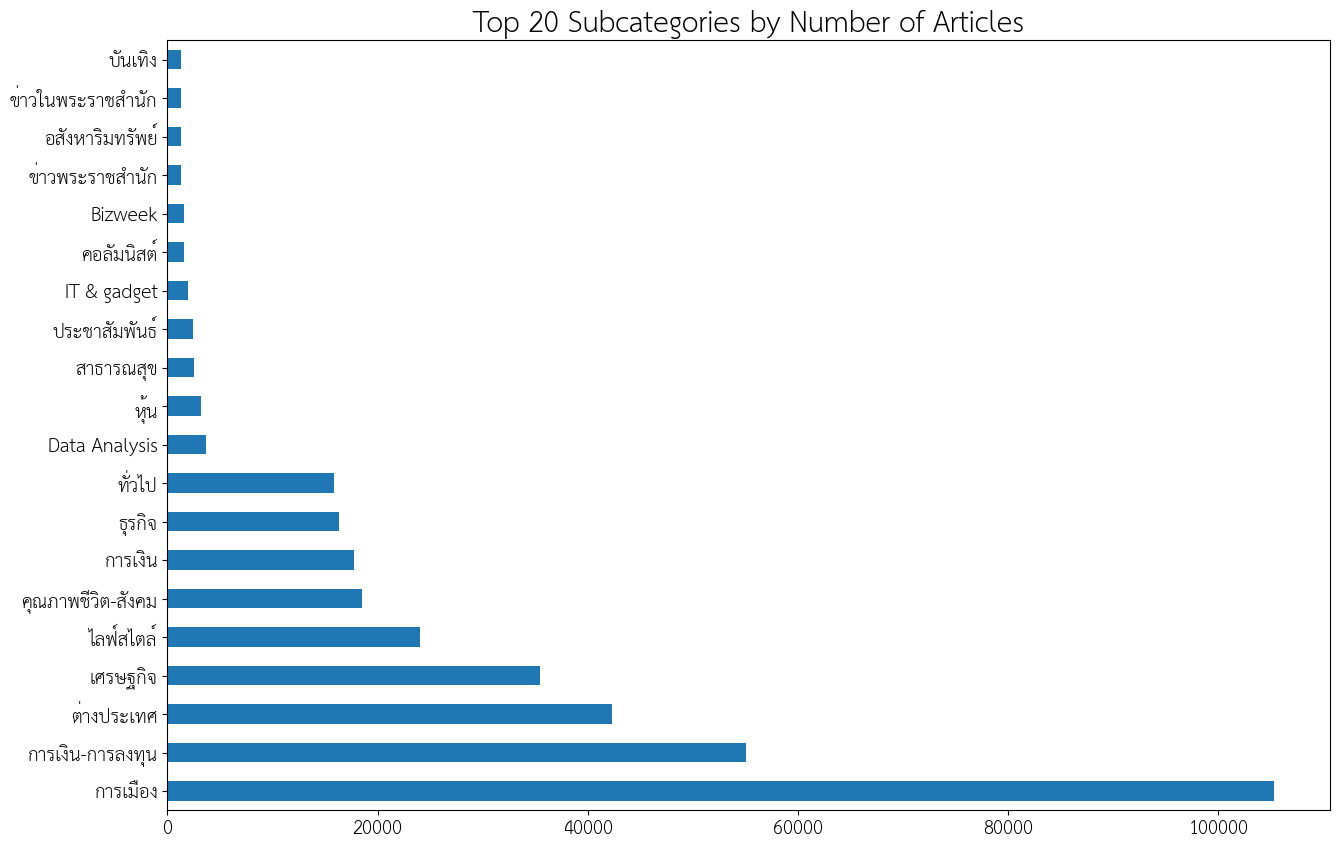

In [11]:
# Top 20 subcategories by number of articles
plt.figure(figsize=(15,10))
plt.title('Top 20 Subcategories by Number of Articles', size=30)
bkkbiz['category'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh');

In [12]:
# Time released
bkkbiz['date'].dt.year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [13]:
# Number of Article by Year
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count()

date
2014     4646
2015    51297
2016    25825
2017    51332
2018    34992
2019    36653
2020    53321
2021    63939
2022    39223
Name: title, dtype: int64

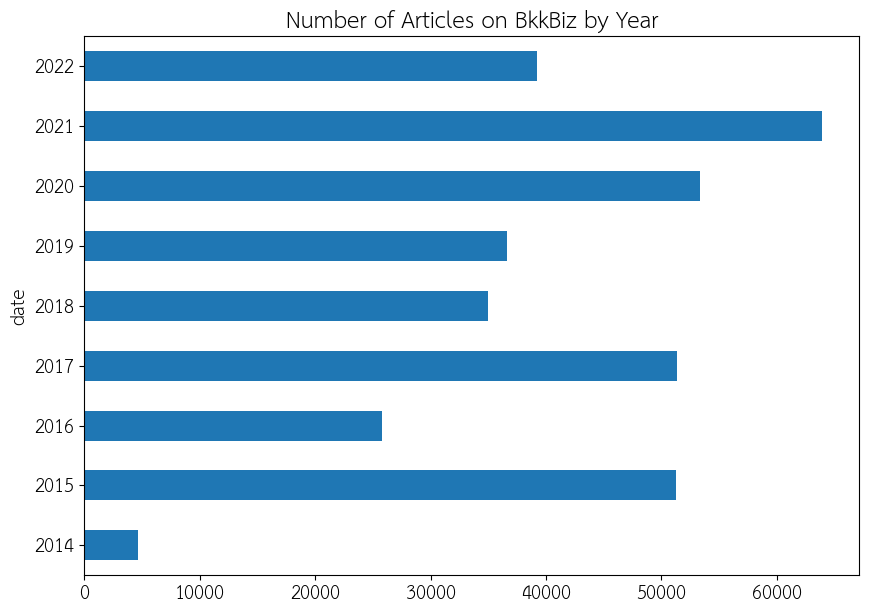

In [14]:
# Number of Article by Year
plt.figure(figsize=(10,7))
plt.title('Number of Articles on BkkBiz by Year')
bkkbiz.groupby(bkkbiz['date'].dt.year)['title'].count().plot(kind='barh');

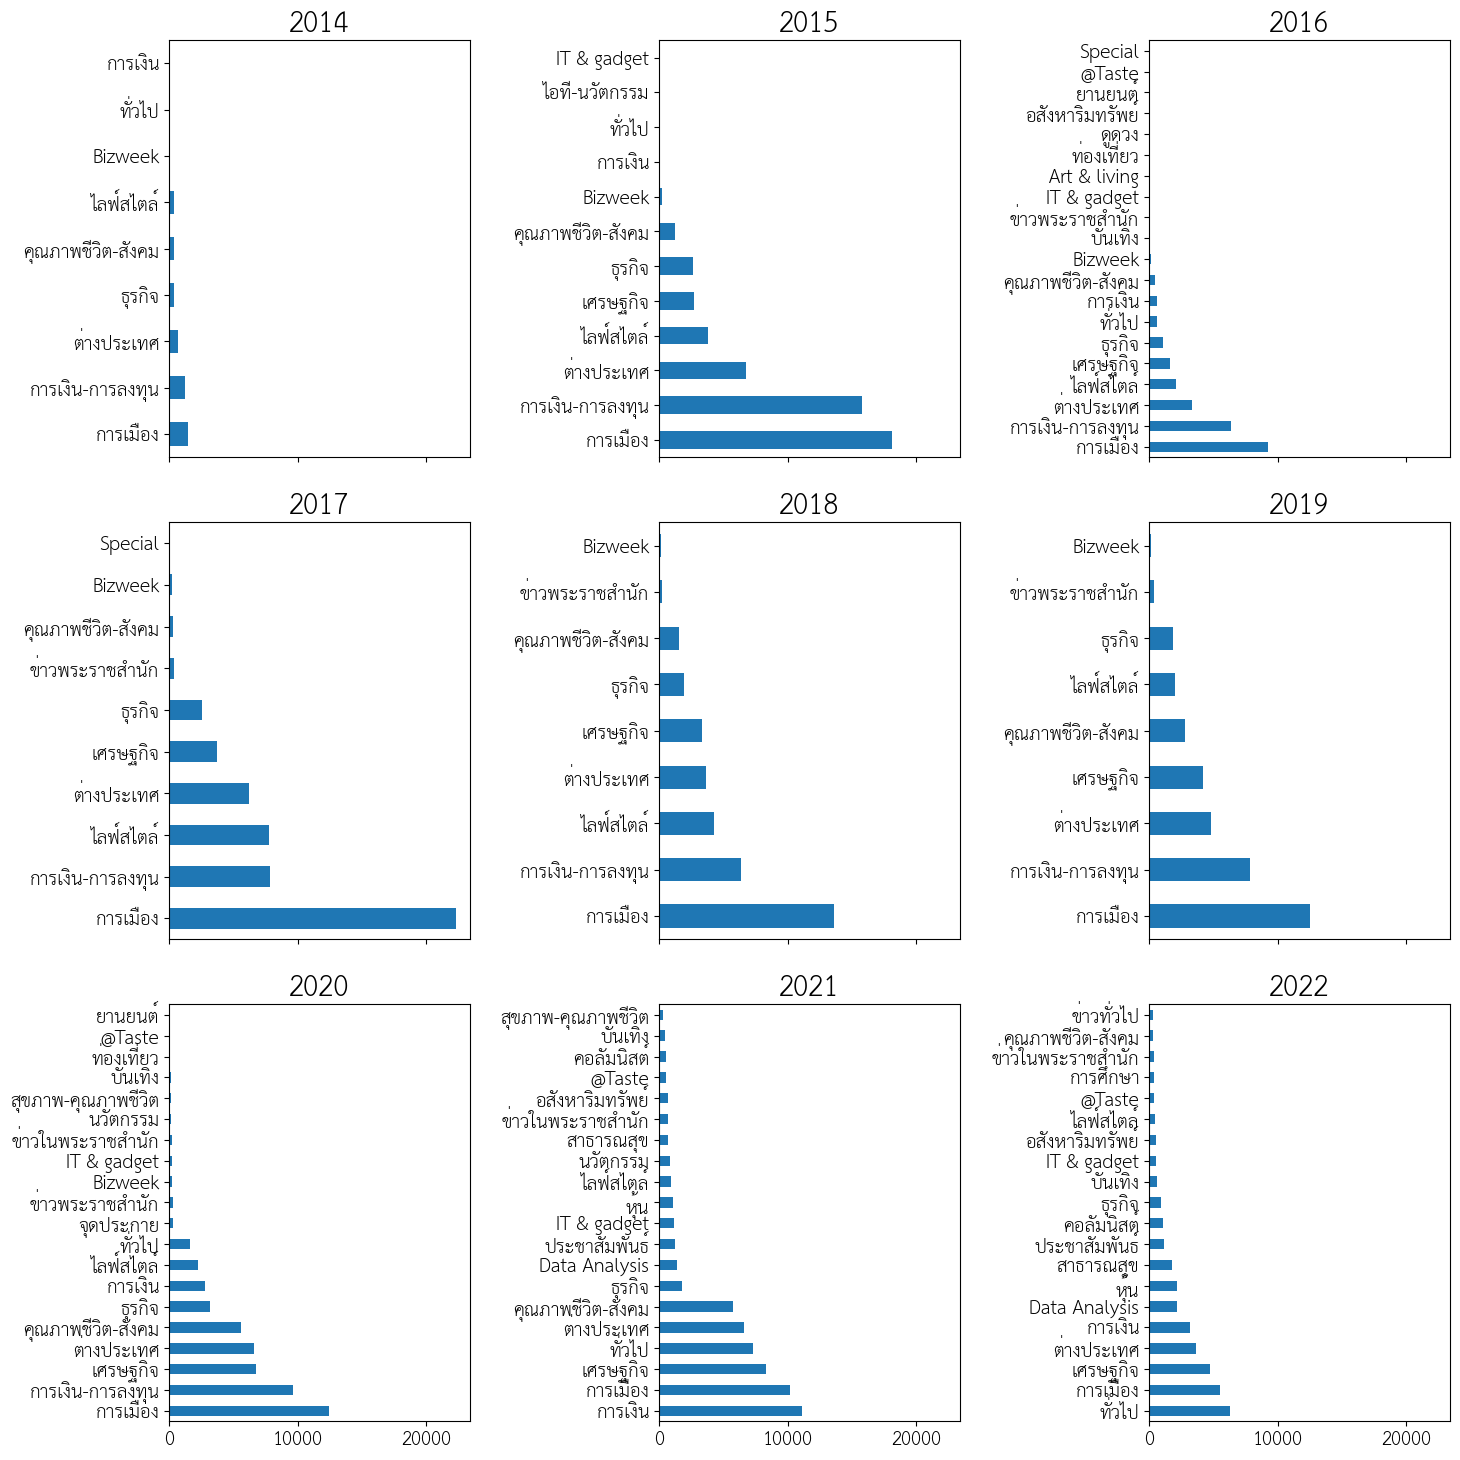

In [15]:
# Number of articles by category by year
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

fig, axs = plt.subplots(3,3, figsize=(15,15), sharex=True)
for n, year in enumerate(years):
  plt.subplot(3,3,n+1)
  plt.title(year, size=30)
  plt.tight_layout()
  bkkbiz[bkkbiz['date'].dt.year==year]['category'].value_counts().head(20).plot(kind='barh');

In [16]:
bkkbiz['category'].unique()

array(['ต่างประเทศ', 'การเงิน-การลงทุน', 'การเมือง', 'คุณภาพชีวิต-สังคม',
       'ธุรกิจ', 'ไลฟ์สไตล์', 'Bizweek', 'ทั่วไป', 'การเงิน', 'เศรษฐกิจ',
       'ไอที-นวัตกรรม', 'IT & gadget', 'ท่องเที่ยว', 'Art & living',
       'บันเทิง', 'ยานยนต์', 'อสังหาริมทรัพย์', 'ดูดวง', '@Taste',
       'ข่าวพระราชสำนัก', 'Special', 'จุดประกาย', 'Data Analysis',
       'ข่าวในพระราชสำนัก', 'นวัตกรรม', 'สุขภาพ-คุณภาพชีวิต',
       'สิ่งแวดล้อม', 'ข่าวทั่วไป', 'เศรษฐกิจ-ธุรกิจ', 'ประชาสัมพันธ์',
       'CEO Blog', 'คอลัมนิสต์', 'การศึกษา', 'ความงาม-แฟชั่น',
       'Training Course', 'Biz2U', 'หุ้น', 'Corporate Moves', 'ลอตเตอรี่',
       'สาธารณสุข', 'แรงงาน', 'เทคโนโลยี', 'คุณภาพชีวิต'], dtype=object)

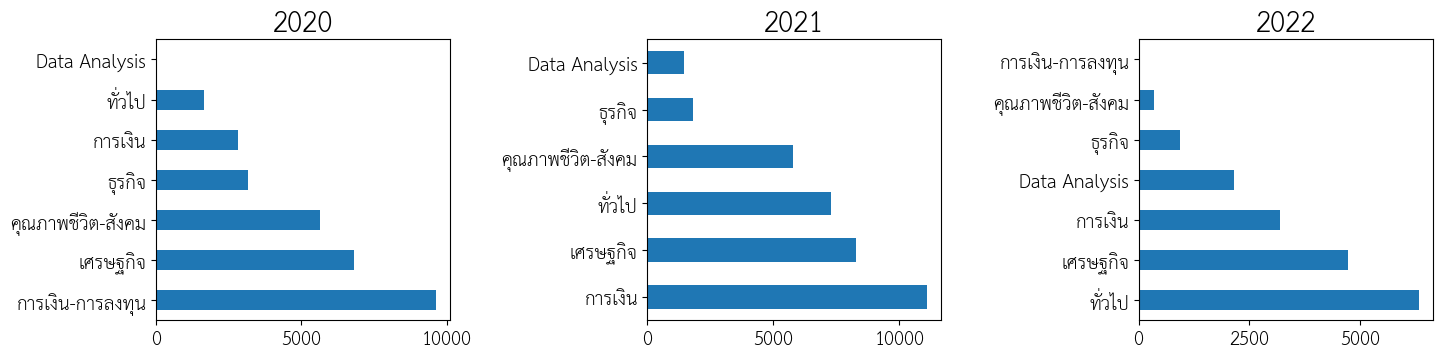

In [17]:
# Number of articles by selected 6 categories from 2020 to 2022
#fig, ax = plt.subplots(4,2, figsize=(15,30))
years = [2020, 2021, 2022]
category = ['การเงิน-การลงทุน', 'การเงิน', 'เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']

fig, axs = plt.subplots(3,3, figsize=(15,4), sharex=True)
for n, year in enumerate(years):   
    plt.subplot(1,3,n+1)
    plt.title(year, size=30)
    plt.tight_layout()
    bkkbiz[(bkkbiz['date'].dt.year==year) & (bkkbiz['category'].isin(category))]['category'].value_counts().head(20).plot(kind='barh')

## 1.4 Pre-Processing
---



#### Pre-processing workflows
1. create new DataFrame \
2. count words: 'title', 'description', 'article' \
3. list: tokenize + remove stop words + RegEx \
4. unlist: tokenize + remove stop words + RegEx

- Create new DataFrame based on articles from the following categories: 

Reasons
- total amount of articles
- constant number of article across years
| category | DataFrame Name |
| ---| ---|
| การเงิน-การลงทุน + การเงิน | finance |
| เศรษฐกิจ| econ |
| คุณภาพชีวิต-สังคม | social |
| ธุรกิจ | business |
| Data analysis | data |
| ทั่วไป | general | 

In [18]:
# Create function that tokenize, remove stopwords and perform RegularExpression
def tokenize(txt):
  
    ''' 
    Description:
        A function that returns tokenized words with stop words and other regular expressions 
        that do not match English and Thai alphabets removed

    Parameters:
        txt = text string

    Return:
        word tokens as list
    '''

    stopwords = thai_stopwords()
    tokens = word_tokenize(txt, keep_whitespace = False)
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [token for token in tokens if re.match(r'[A-Za-zก-๙0-9]+', token)]
    return tokens

In [19]:
# Write a function for generating new DataFrame 

# List of columns
cols = ['title', 'description', 'article']

def new_df(data=None):

    '''
    Description:
        A function that create a new DataFrame from existing bkkbiz corpus 
        The following new features will be created as a result of the function:
          1. word count
          2. tokenized words list
          3. tokenized words outside of a list
    Parameters:
        Name of the new DataFrame
    Returns:
        New DataFrame
    '''

    # 1. Create new DataFrame
    new_df = data.reset_index(drop=True)

    # 2. Create word count columns
    for col in tqdm(cols):
        new_df[col+'_count'] = new_df[col].\
                                apply(lambda x: len(word_tokenize(x ,keep_whitespace=False)))

        # 3. Tokenize, remove stop words, perform regular expression > ready for topic modeling
        new_df[col+'_tokenize'] = new_df[col].apply(tokenize)

        # 4. Take the tokens out of the list > ready to be vectorized
        #new_df[col+'_tokenize_unlist'] = new_df[col+'_tokenize_list'].apply(lambda x:' '.join(x))

    return new_df

In [20]:
bkkbiz['category'].unique()

array(['ต่างประเทศ', 'การเงิน-การลงทุน', 'การเมือง', 'คุณภาพชีวิต-สังคม',
       'ธุรกิจ', 'ไลฟ์สไตล์', 'Bizweek', 'ทั่วไป', 'การเงิน', 'เศรษฐกิจ',
       'ไอที-นวัตกรรม', 'IT & gadget', 'ท่องเที่ยว', 'Art & living',
       'บันเทิง', 'ยานยนต์', 'อสังหาริมทรัพย์', 'ดูดวง', '@Taste',
       'ข่าวพระราชสำนัก', 'Special', 'จุดประกาย', 'Data Analysis',
       'ข่าวในพระราชสำนัก', 'นวัตกรรม', 'สุขภาพ-คุณภาพชีวิต',
       'สิ่งแวดล้อม', 'ข่าวทั่วไป', 'เศรษฐกิจ-ธุรกิจ', 'ประชาสัมพันธ์',
       'CEO Blog', 'คอลัมนิสต์', 'การศึกษา', 'ความงาม-แฟชั่น',
       'Training Course', 'Biz2U', 'หุ้น', 'Corporate Moves', 'ลอตเตอรี่',
       'สาธารณสุข', 'แรงงาน', 'เทคโนโลยี', 'คุณภาพชีวิต'], dtype=object)

In [21]:
# Create a list of years & category
years = [2020, 2021, 2022]
categories = ['การเงิน-การลงทุน', 'การเงิน', 'เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']

In [22]:
data = bkkbiz[(bkkbiz['date'].dt.year.isin(years)) & ((bkkbiz['category']=='การเงิน-การลงทุน') | (bkkbiz['category']=='การเงิน'))]
data.groupby(bkkbiz['date'].dt.year)['title'].count()
#investment = new_df(data=bkkbiz)
#bkkbiz.head(1)

date
2020    12442
2021    11107
2022     3187
Name: title, dtype: int64

In [23]:
'''
for category in categories:
    data = bkkbiz[(bkkbiz['date'].dt.year.isin(years)) & ((bkkbiz['category']==category))]
    df_name = category
    df_name = new_df(data=data)
    df_name.to_json(f'../datasets/{category}_processed.json')
    print(f'Finish processing and saving "{category}" yayyy!')'''

'\nfor category in categories:\n    data = bkkbiz[(bkkbiz[\'date\'].dt.year.isin(years)) & ((bkkbiz[\'category\']==category))]\n    df_name = category\n    df_name = new_df(data=data)\n    df_name.to_json(f\'../datasets/{category}_processed.json\')\n    print(f\'Finish processing and saving "{category}" yayyy!\')'

In [24]:
# COLAB
# Download 
# for key in df_dict:
#  files.download(f'{key}.csv')
#  print(f'Finish downloading "{key}" DataFrame')

## 1.5 Modeling

In [25]:
# Merge การเงิน and การเงิน-การลงทุน as finance
df_1 = pd.read_json('../datasets/การเงิน_processed.json')
df_2 = pd.read_json('../datasets/การเงิน-การลงทุน_processed.json')
finance = pd.concat([df_1, df_2], ignore_index=True)

# Create 'economic' DataFrame
economic = pd.read_json(f'../datasets/เศรษฐกิจ_processed.json')

# Create 'social' DataFrame
social = pd.read_json(f'../datasets/คุณภาพชีวิต-สังคม_processed.json')

# Create 'business' DataFrame
business = pd.read_json(f'../datasets/ธุรกิจ_processed.json')

# Create 'data_analysis' DataFrame
data_analysis = pd.read_json(f'../datasets/Data Analysis_processed.json')

# Create 'general' DataFrame
general = pd.read_json(f'../datasets/ทั่วไป_processed.json')

# Create new DF by categories
#variables = ['economic', 'social', 'business', 'data', 'general']
#categories = ['เศรษฐกิจ', 'คุณภาพชีวิต-สังคม', 'ธุรกิจ', 'Data Analysis', 'ทั่วไป']
#for i in range(5):
#    df_name = variables[i]
#    print(df_name)
#    df_name = pd.read_json(f'../datasets/{categories[i]}_processed.json')
#    print(f'../datasets/{categories[i]}_processed.json')'''

In [26]:
names = ['finance', 'economic', 'social', 'business', 'data', 'general']
dfs = [finance, economic, social, business, data, general]

for n, df in enumerate(dfs):
    print(f'Shape of {names[n]}: {df.shape}')

Shape of finance: (26736, 13)
Shape of economic: (19821, 13)
Shape of social: (11762, 13)
Shape of business: (5903, 13)
Shape of data: (26736, 7)
Shape of general: (15252, 13)


In [27]:
# Data Analysis ทำไมไม่เท่าคนอื่น

In [28]:
for df in dfs:
    print(df.isnull().sum())

ID                      0
date                    0
category                0
title                   0
description             0
article                 0
url                     0
title_count             0
title_tokenize          0
description_count       0
description_tokenize    0
article_count           0
article_tokenize        0
dtype: int64
ID                      0
date                    0
category                0
title                   0
description             0
article                 0
url                     0
title_count             0
title_tokenize          0
description_count       0
description_tokenize    0
article_count           0
article_tokenize        0
dtype: int64
ID                      0
date                    0
category                0
title                   0
description             0
article                 0
url                     0
title_count             0
title_tokenize          0
description_count       0
description_tokenize    0
article_coun

In [29]:
# Function for creating new corpus
def lda_corpus(data=None):
    dictionary = Dictionary(data)
    corpus = [dictionary.doc2bow(txt) for txt in data]
    return dictionary, corpus

In [30]:
# Function for modeling with LDA
def lda_model(dictionary=None, corpus=None, num_topics=None): #, topicid=None
    model = LdaModel(corpus=corpus, num_topics=num_topics)
    topic = pd.DataFrame(model.get_topic_terms(topicid=1, topn=20)).rename(columns={0:'index', 1:'probability'})
    for i in range(num_topics):
        top_n = [dictionary[index] for index, prob in model.get_topic_terms(topicid=i, topn=20)]
        print(f'Topic {i+1}')
        print(top_n)
        print('-'*60)
    return model, topic


In [31]:
names = ['finance', 'economic', 'social', 'business', 'general']
dfs = [finance, economic, social, business, general]

In [32]:
for i in range(5):
    print(f'{names[i].upper()}')
    print('*'*60)
    
    corpus = lda_corpus(data=dfs[i]['article_tokenize'])
    model = lda_model(dictionary = corpus[0], 
            corpus = corpus[1], 
            num_topics=10)
    model
    
    print(' ')
    print(' ')

FINANCE
************************************************************
Topic 1
['ไทย', 'ดัชนี', 'สหรัฐ', 'ปี', 'ตลาด', 'หุ้น', '19', 'ปรับตัว', 'โควิด', 'จุด', 'เศรษฐกิจ', 'ประเทศ', 'ราคา', 'จีน', 'ลดลง', 'เดือน', 'บาท', 'ระดับ', 'ปัจจัย', 'ล้าน']
------------------------------------------------------------
Topic 2
['บาท', 'เพิ่มขึ้น', 'ลดลง', 'การซื้อขาย', 'Futures', 'สัญญา', 'ราคา', '50', 'ผู้ลงทุน', 'อันดับ', '5', 'SET', 'Gold', 'ปริมาณ', 'มูลค่า', 'หลักทรัพย์', 'จุด', '10', '20', 'ประเภท']
------------------------------------------------------------
Topic 3
['กรมอุตุนิยมวิทยา', 'Pro', 'เดือน', 'Mi', 'ปัง', 'T', 'ฝนตก', 'คาด', 'จีน', 'ไทย', 'ตลาดหุ้น', 'พยากรณ์อากาศ', '10', 'ราคา', 'ล้าน', 'ต่อเนื่อง', 'หนัก', 'Tesla', '3', '2']
------------------------------------------------------------
Topic 4
['บริษัท', 'ปี', 'ธุรกิจ', 'ไทย', 'ล้าน', 'ประเทศ', 'ลูกค้า', '19', '2563', 'สำหรับ', 'โควิด', 'เอสเอ็มอี', 'จ่าย', 'ผลกระทบ', 'สินเชื่อ', 'ธนาคาร', 'การลงทุน', 'สภาพคล่อง', '2', '3']
-------

In [34]:
# finance
dictionary_finance = Dictionary(finance['article_tokenize'])
corpus_finance = [dictionary_finance.doc2bow(txt) for txt in finance['article_tokenize']]
model_finance = LdaModel(corpus=corpus_finance, num_topics=20)
    

In [35]:
import warnings
warnings.filterwarnings('ignore') 
#warnings.filterwarnings('ignore', category=FutureWarning) 

In [36]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import numpy as np

In [39]:
import warnings as wa
wa.warn_explicit = wa.warn = lambda *_, **__: None

In [42]:
import logging

logging.captureWarnings(capture=True)

# Get logger for warnings
logger = logging.getLogger("py.warnings")

# StreamHandler outputs on sys.stderr by default
handler = logging.StreamHandler()
logger.addHandler(handler)

# Set rule to ignore warnings
logger.addFilter(lambda record: "DeprecationWarning" not in record.getMessage())

In [43]:
# Visualization
def lda_vis(data=None, num_topics=20):
    dictionary = Dictionary(data)
    corpus = [dictionary.doc2bow(txt) for txt in data]
    model = LdaModel(corpus=corpus, num_topics=num_topics)
    pyLDAvis.enable_notebook()
    viz = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    return viz

In [44]:
lda_vis(data=finance['article_tokenize'])

/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Anik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.181419 -0.054411       1        1  11.942705
16    -0.064713  0.052067       2        1  10.414911
0      0.022123 -0.112705       3        1  10.240395
4     -0.128290 -0.107360       4        1   7.776920
17    -0.076963  0.062733       5        1   6.584249
18    -0.099863 -0.044653       6        1   6.194488
10    -0.169072 -0.003385       7        1   6.107217
1     -0.136065 -0.074108       8        1   5.144415
3     -0.121571  0.097488       9        1   4.985905
13    -0.146966 -0.036789      10        1   4.763519
14    -0.105620  0.089603      11        1   4.585089
15     0.084692 -0.080241      12        1   4.046577
11     0.025656 -0.093095      13        1   3.451442
7      0.275599 -0.195658      14        1   2.866550
12    -0.028989  0.038920      15        1   2.390175
5      0.147556  0.331020      16        1   2.226810
2      0.119729  0.219222      17        1   1.704086
19     0.349437 -0.105635      18        1   1.586910
9     -0.057891 -0.025467      19        1   1.527037
6      0.292629  0.042454      20        1   1.460598, topic_info=        Term          Freq         Total Category  logprob  loglift
16       บาท  93414.000000  93414.000000  Default  30.0000  30.0000
230     ราคา  34498.000000  34498.000000  Default  29.0000  29.0000
304   บริษัท  36454.000000  36454.000000  Default  28.0000  28.0000
93        20  21137.000000  21137.000000  Default  27.0000  27.0000
82      หุ้น  48006.000000  48006.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
586      ไทย    570.127639  36746.884882  Topic20  -4.8001   0.0604
16       บาท    587.334762  93414.619028  Topic20  -4.7703  -0.8429
56     ดัชนี    540.062434  17691.907707  Topic20  -4.8542   0.7371
229    ระดับ    482.210187  21211.713709  Topic20  -4.9675   0.4424
1282       ส    474.689410   2603.693621  Topic20  -4.9833   2.5243

[1693 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
3688       3  0.072414    0.10
3688       5  0.017479    0.10
3688      12  0.002497    0.10
3688      13  0.004994    0.10
3688      14  0.027467    0.10
...      ...       ...     ...
1489      17  0.000880   ไวรัส
1489      18  0.000220   ไวรัส
1489      19  0.000440   ไวรัส
15658     12  0.987386  ไอเดีย
14328      7  0.982242      ์น

[9046 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 17, 1, 5, 18, 19, 11, 2, 4, 14, 15, 16, 12, 8, 13, 6, 3, 20, 10, 7])

In [ ]:
lda_vis(data=social['article_tokenize'])

In [ ]:
lda_vis(data=economic['article_tokenize'])

In [ ]:
lda_vis(data=business['article_tokenize'])

In [ ]:
lda_vis(data=general['article_tokenize'])

In [ ]:
# Create new DataFrame
# for key in df_dict:
#  df = cat_df(key)
#  df.to_csv(f'{key}.csv')
#  print(f'Finish creating "{key}" DataFrame')